In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#import torch which has many of the functions to build deep learning models and to train them
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import torchvision, which was lots of functions for loading and working with image data
import torchvision
import torchvision.transforms as transforms

#this is a nice progress bar representation that will be good to measure progress during training
import tqdm

In [2]:
#load data with true means
imagenet_means = (0.420, 0.395, 0.323)
imagenet_stds = (0.258, 0.243, 0.248)

transform = transforms.Compose(
    [transforms.ToTensor(),
     #224 x 224
    transforms.Resize((224,224)),
    transforms.Normalize(imagenet_means, imagenet_stds),
    ])

full_data = torchvision.datasets.ImageFolder('trainval', transform = transform)

In [3]:
#separate in val and train
train_portion = 0.8
val_portion = 0.2

all_idxes = np.arange(len(full_data))
all_targets=[data[1] for data in full_data]

train_idx, val_idx = train_test_split(all_idxes, train_size=train_portion, stratify = all_targets, random_state = 0)


train_dataset = torch.utils.data.Subset(full_data, train_idx)
val_dataset = torch.utils.data.Subset(full_data, val_idx)

train_labels=[data[1] for data in train_dataset]
val_labels=[data[1] for data in val_dataset]

print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of val dataset: {len(val_dataset)}')

lbls, counts = np.unique(train_labels, return_counts = True)

weighting = torch.DoubleTensor([1/x for x in counts])
sample_weights = weighting[train_labels]

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(train_dataset))

batch_size = 4

balanced_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          sampler = sampler)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False)

Size of train dataset: 964
Size of val dataset: 241


In [4]:
#tranform inputs

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomRotation(degrees=(0, 360)),
     transforms.RandomResizedCrop(size=(224,224), scale=(0.7, 1.0))
    ])

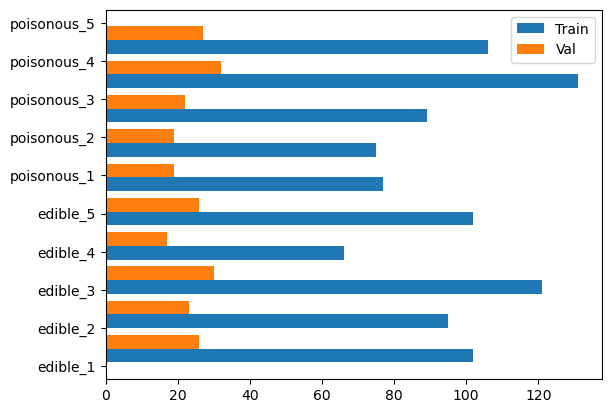

In [5]:
#visualize the balance of the classes
num_classes=len(full_data.classes)
class_labels= full_data.classes

plt.hist([train_labels, val_labels], label=["Train", "Val"], orientation='horizontal')
plt.yticks([i for i in range(10)], class_labels)
plt.legend()

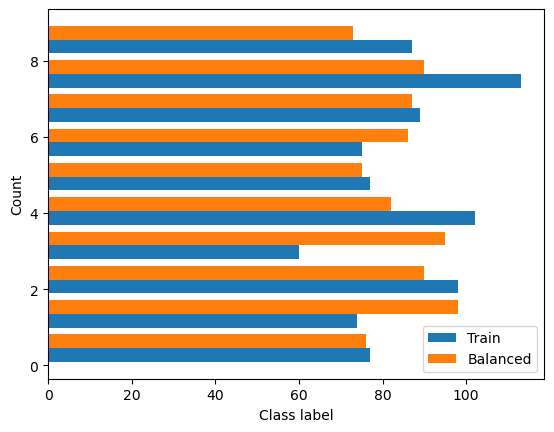

In [6]:
#load model

torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available

dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dino.eval()
dino.to(device)
for data in trainloader:
    inputs, labels = data

    inputs = inputs.to(device)
    feature = dino(inputs)

    print(feature.size())
    break

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /tmp/.cache/torch/hub/main.zip
/tmp/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/tmp/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/tmp/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /tmp/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 201MB/s]


torch.Size([4, 384])


In [7]:
#create non linear network

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(384, 128)
        self.fc2 = nn.Linear(128,10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        y = self.relu(self.fc2(x))
        return y

In [8]:
#train 
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available
#any hyperparameters
lr = 0.001
total_epochs = 30

#Step 1: Initialise the model.
model= LinearClassifier()
model.to(device)
# Step 2: Define a loss function
criterion = nn.CrossEntropyLoss()
# Step 3: Initialise the SGD optimizer.
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

#Step 4: For n epochs (e.g. loss converged/stops changing)
total_train_loss = []
total_train_acc = []
total_val_loss = []
total_val_acc = []
best_acc = 0
for epoch in range(total_epochs):    
    #Step 4A: Put the model in "train" mode
    model.train() 

    #Step 4B: Training loop: For all batches in the training dataset
    train_loss = []
    correct = 0
    total = 0
    for i, data in  tqdm.tqdm(enumerate(trainloader, 0), total = len(trainloader), desc = f'Epoch {epoch+1} - training phase'):
        inputs, labels = data
        inputs = inputs.to(device)

        inputs = train_transform(inputs)

        inputs=dino(inputs)
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        train_loss += [loss.cpu().item()]
        
        predicted = torch.argmax(outputs, axis = 1)
        
        correct += torch.sum(predicted == labels).cpu().item()
        total += len(labels)
        
    mean_train_loss = np.mean(train_loss)
    train_accuracy = correct/total

    total_train_loss += [mean_train_loss]
    total_train_acc += [train_accuracy]
    
    #Step 4C: Put the model in "eval" mode
    model.eval()

    #Step 4D: Validation loop: For all batches in the validation dataset
    val_loss=[]
    correct=0
    total=0
    for i,data in tqdm.tqdm(enumerate(valloader,0), total=len(valloader), desc = f'Epoch {epoch+1} - validation phase'):
        inputs, labels= data
        inputs=inputs.to(device)
        inputs = dino(inputs)
    
        inputs = inputs.to(device)
        labels =labels.to(device)
    
        outputs=model(inputs)
    
        loss=criterion(outputs, labels)
        
        predicted =torch.argmax(outputs, axis=1)
    
        correct+= torch.sum(predicted == labels).cpu().item()
        total+=len(labels)

        val_loss+=[loss.cpu().item()]
    
    mean_val_loss = np.mean(val_loss)
    val_accuracy = correct/total

    total_val_loss += [mean_val_loss]
    total_val_acc += [val_accuracy]

Epoch 30 - validation phase: 100%|██████████| 61/61 [00:02<00:00, 20.82it/s]


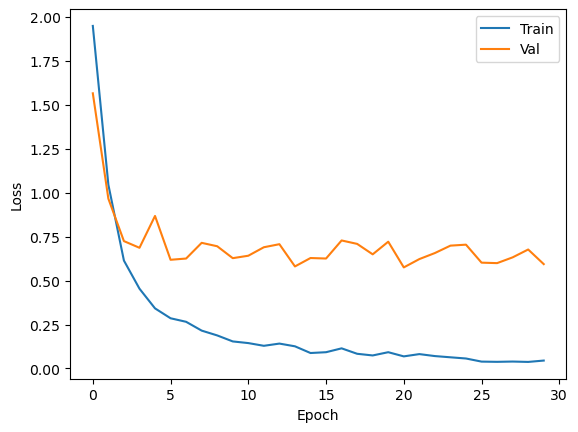

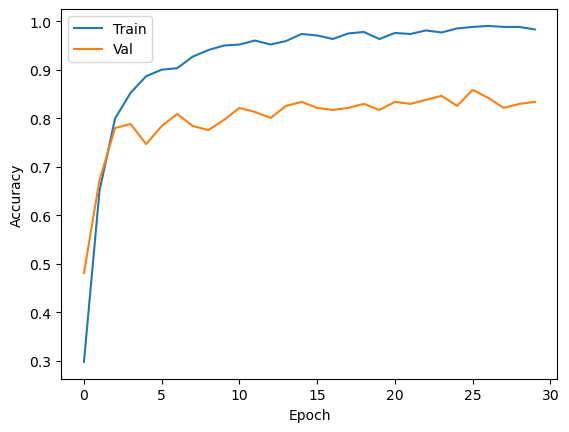

0.9906639004149378
0.8589211618257261


In [9]:
plt.plot(total_train_loss, label = 'Train')
plt.plot(total_val_loss, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(total_train_acc, label = 'Train')
plt.plot(total_val_acc, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

print(max(total_train_acc))
print(max(total_val_acc))

In [11]:
torch.save(model.state_dict(), 'first_model.pth')

In [10]:
gt=[]
pred=[]
model.eval()

for data in valloader:
    
    inputs, labels = data
    inputs = inputs.to(device)
    inputs=dino(inputs)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)

    predicted = torch.argmax(outputs, axis=1)
    pred +=predicted.tolist()
    gt+=labels.tolist()


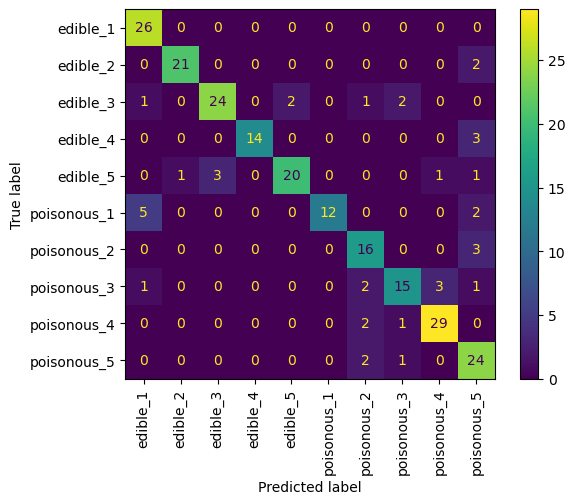

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(gt, pred, display_labels= class_labels, xticks_rotation='vertical')

In [12]:
gt=[]
pred=[]


for data in valloader:
    inputs, labels = data
    inputs = inputs.to(device)
    inputs=dino(inputs)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)

    predicted = torch.argmax(outputs, axis=1)

    for i in range (len(predicted)):
        gt_name = class_labels[labels[i]]
        pred_name = class_labels[predicted[i]]
        
        gt_edible = ("poisonous" not in gt_name)
        pred_edible =  ("poisonous" not in pred_name)
        
        pred.append(pred_edible)
        gt.append(gt_edible)

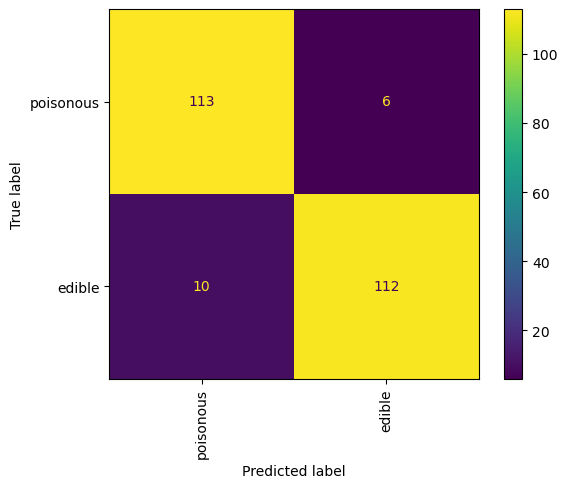

In [13]:
ConfusionMatrixDisplay.from_predictions(gt, pred, display_labels= ["poisonous", "edible"], xticks_rotation='vertical')

In [38]:
gt=[]
pred=[]


for data in valloader:
    inputs, labels = data
    inputs = inputs.to(device)
    inputs=dino(inputs)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    outputs = torch.nn.functional.softmax(outputs) 
    confidence, predicted = torch.max(outputs, axis=1)

    for i in range (len(predicted)):
        gt_name = class_labels[labels[i]]
        pred_name = class_labels[predicted[i]]
        
        gt_edible = ("poisonous" not in gt_name)
        pred_edible =  ("poisonous" not in pred_name)
        if(confidence[i]<0.95): pred_edible = False;
        
        pred.append(pred_edible)
        gt.append(gt_edible)

/tmp/ipykernel_83/2824127284.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs)


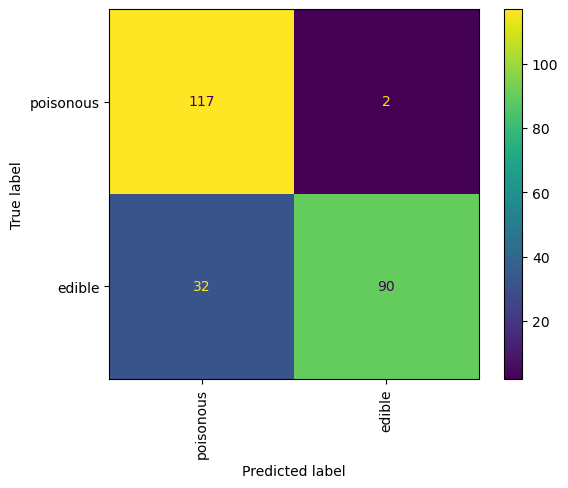

In [39]:
ConfusionMatrixDisplay.from_predictions(gt, pred, display_labels= ["poisonous", "edible"], xticks_rotation='vertical')

In [15]:
all_gt = []
all_pred =[]
all_confidences =[]
for data in valloader:
    inputs, labels = data
    inputs = inputs.to(device)
    inputs=dino(inputs)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    softmax=torch.nn.functional.softmax(outputs)
    confidence, predicted =torch.max(softmax, axis=1)
    all_confidences+=confidence.tolist()
    all_pred+=predicted.tolist()
    all_gt+=labels.tolist()

/tmp/ipykernel_86/3669977552.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax=torch.nn.functional.softmax(outputs)


/tmp/ipykernel_86/2049154255.py:26: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct/total


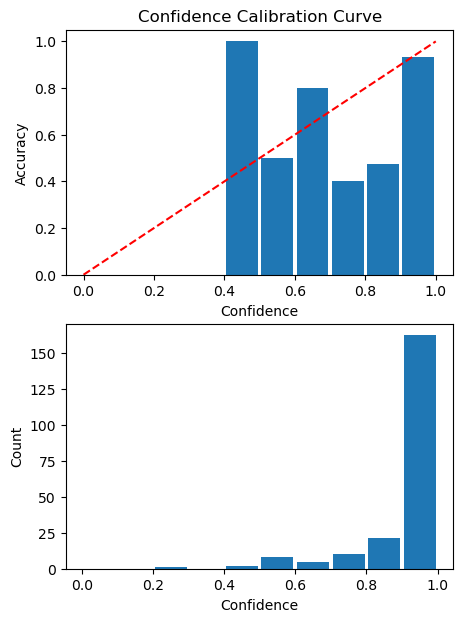

[nan, nan, 0.0, nan, 1.0, 0.5, 0.8, 0.4, 0.47619047619047616, 0.9320987654320988]
[0, 0, 1, 0, 2, 8, 5, 10, 21, 162]


In [18]:
#create a variable that holds the confidence intervals we will check on a confidence calibration curve
conf_ranges = [[0, 10], [10, 20], [20, 30], [30, 40], [40, 50], [50, 60], [60, 70], [70, 80], [80, 90], [90, 100]] 

#convert our previously collected lists into numpy arrays so that we can easily manipulate them
all_pred_conf = np.array(all_confidences)
all_pred_class = np.array(all_pred)
all_gt_class = np.array(all_gt)

actual_accuracy = []
conf_level = []
conf_counts = []
for conf_int in conf_ranges:
    lower = conf_int[0]/100 #convert between 0-1
    upper = conf_int[1]/100 #convert between 0-1

    #create a mask that will collect predictions in the confidence interval -- it must be above the lower thresh AND below the upper thresh
    mask = (all_pred_conf >= lower) & (all_pred_conf < upper)
    
    #collect all predictions and GT data within the range using the mask
    preds = all_pred_class[mask]
    gt = all_gt_class[mask]
    
    #find the accuracy of this bin by checking how many correct/total
    correct = np.sum(preds == gt)
    total = len(preds)
    accuracy = correct/total
    actual_accuracy += [accuracy] #save the accuracy for this bin to plot later
    conf_level += [(upper + lower)/2] #this is the average confidence level for this confidence interval (not necessarily for the predictions in the bin though), we will use this for plotting later

    #how many samples in this bin?
    conf_counts += [len(preds)]


#Create a figure 
fig, ax = plt.subplots(2, 1, figsize = (5, 7))
ax[0].bar(conf_level, actual_accuracy, width = 0.09)
ax[0].plot([0, 1], [0, 1], 'r--') #our well-calibrated line
ax[0].set_xlabel('Confidence')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Confidence Calibration Curve')

ax[1].bar(conf_level, conf_counts, width = 0.09)
ax[1].set_xlabel('Confidence')
ax[1].set_ylabel('Count')

plt.savefig('Confidence_curve.png')
plt.show()
print(actual_accuracy)
print(conf_counts)